In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOVICAT2 as HALOVICAT
from complementary_models import HALOVAECAT2 as HALOVAECAT
import scanpy as sc
import scvi
import pandas as pd
torch.autograd.set_detect_anomaly(True) 


Global seed set to 0


In [2]:
## load the data
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)


In [3]:
## Merge Data
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'time_key']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
adata_mvi.obs

,celltype,batch_id,modality,time_key
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired,12
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired,5
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired,17
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired,19
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired,10
...,...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired,9
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired,11
TTTGTGTTCAATGACC-1_paired,IPC,1,paired,5
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired,15


In [4]:
HALOVICAT.setup_anndata(adata_mvi, batch_key="modality", time_key='time_key')
mvi_p = HALOVICAT(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    alpha=0.02,
    beta_1=1e6,
    beta_2=1e7,
    beta_3=100,
    n_latent_dep=15,
    n_latent_indep=5
)

time key in registry : True
cell type key in registry: False


In [5]:
mvi_p.train(use_gpu=True, batch_size=512, max_epochs=150)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 150/150: 100%|██████████| 150/150 [08:17<00:00,  3.32s/it, loss=3.48e+04, v_num=1]


In [13]:
mvi_p.save("./cat_models/model_stronger_alternative_3")

In [5]:
## load models of HALO
mvi_p = mvi_p.load("./cat_models/model_stronger_alternative_3", adata=adata_mvi)

INFO     File ./cat_models/model_stronger_alternative_3/model.pt already downloaded          
time key in registry : True
cell type key in registry: False


In [6]:
mvi_p.train(use_gpu=True, batch_size=512, max_epochs=80)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/80:   0%|          | 0/80 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


before reconstructon loss 36268.9140625, nod_loss 5083.660383801745
after reconstructon loss 5083.66015625, beta:1000000.0
before reconstructon loss 35096.796875, nod_loss 7113.261973901843
after reconstructon loss 7113.26220703125, beta:1000000.0
before reconstructon loss 36362.71875, nod_loss 6534.33876623901
after reconstructon loss 6534.3388671875, beta:1000000.0
before reconstructon loss 35395.2734375, nod_loss 5889.147800341429
after reconstructon loss 5889.14794921875, beta:1000000.0
before reconstructon loss 35728.19921875, nod_loss 5270.557426142064
after reconstructon loss 5270.5576171875, beta:1000000.0
before reconstructon loss 37126.7265625, nod_loss 4870.424942811785
after reconstructon loss 4870.4248046875, beta:1000000.0
before reconstructon loss 37465.6875, nod_loss 4264.871992349989
after reconstructon loss 4264.8720703125, beta:1000000.0
Epoch 2/80:   1%|▏         | 1/80 [00:03<04:56,  3.76s/it, loss=5.79e+03, v_num=1]before reconstructon loss 36263.0390625, nod_loss

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [7]:

latent_atac, latent_expr, latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times = mvi_p.get_latent_representation()

In [8]:
from complementary_models.infer_nonsta_dir import infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir
score1, _, _ = torch_infer_nonsta_dir(torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(times).to('cuda'))
score1

tensor(0.0091, device='cuda:0', dtype=torch.float64)

In [9]:
score2, _, _= torch_infer_nonsta_dir(torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(times).to('cuda'))
score2

tensor(0.0091, device='cuda:0', dtype=torch.float64)

In [10]:
latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score3

tensor(0.0099, device='cuda:0', dtype=torch.float64)

In [11]:
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score4

tensor(0.0100, device='cuda:0', dtype=torch.float64)

In [12]:
score3 - score4

tensor(-0.0001, device='cuda:0', dtype=torch.float64)

In [19]:
adata_mvi.var["feature_types"] == "Gene Expression"

Xkr4                       True
Gm1992                     True
Gm19938                    True
Rp1                        True
Mrpl15                     True
                          ...  
GL456216.1:37994-39286    False
GL456216.1:40534-41810    False
GL456216.1:49045-49376    False
JH584292.1:12573-14868    False
JH584295.1:0-1976         False
Name: feature_types, Length: 138466, dtype: bool

In [16]:
from numpy.linalg import inv
import pandas as pd

X = latent_atac
Y =  latent_expr

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)

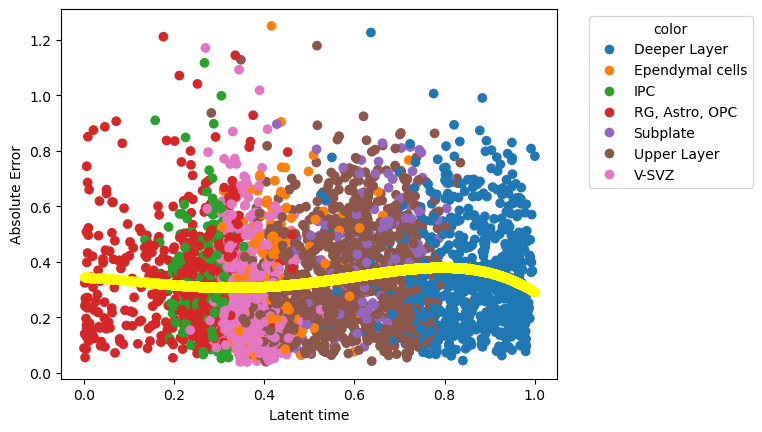

In [17]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


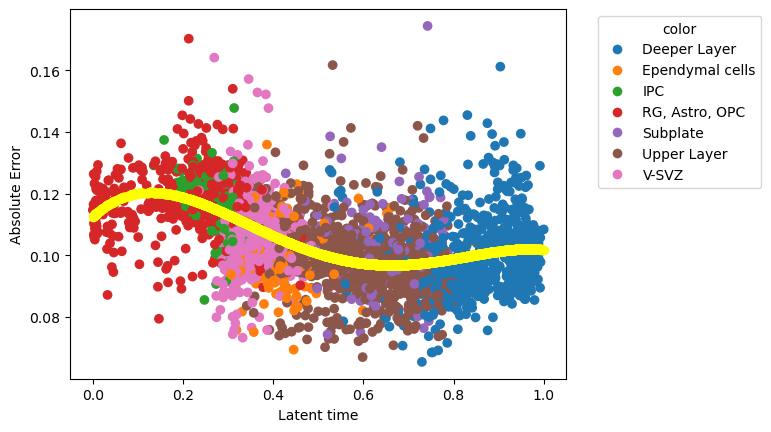

In [18]:
adata_RNA_sub  = adata_multi[:, adata_multi.var['feature_types'] == 'Gene Expression']
sc.pp.normalize_per_cell(adata_RNA_sub)
sc.pp.log1p(adata_RNA_sub)
Y = adata_RNA_sub.X.toarray()
X = latent_atac

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

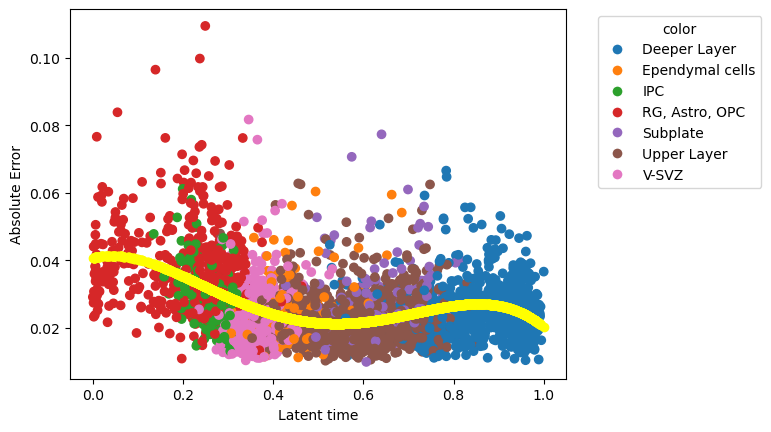

In [19]:
X = latent_atac_dep
Y =  latent_expr_dep


b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

In [21]:
X = latent_atac_indep
Y =  latent_expr_indep


b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

RuntimeError: 1D tensors expected, but got 2D and 2D tensors